In [1]:
# Libraries imports (Some libraries may not be used)

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pickle

pd.set_option("display.max_columns", None)

In [2]:
# This function will be used afterwards to 
def score_classifier(dataset,classifier,labels, n_splits = 3):

    """
    performs random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :param n_splits: number of splits
    :return:
    """

    kf = KFold(n_splits=n_splits,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall_test = 0
    precision_test = 0
    recall_train = 0
    precision_train = 0
    roc_auc_score_train = 0
    roc_auc_score_test = 0
    
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset.iloc[training_ids,:]
        training_labels = labels.iloc[training_ids]
        test_set = dataset.iloc[test_ids,:]
        test_labels = labels.iloc[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_train = classifier.predict(training_set)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall_test += recall_score(test_labels, predicted_labels)
        precision_test += precision_score(test_labels, predicted_labels)
        recall_train += recall_score(training_labels, predicted_train)
        precision_train += precision_score(training_labels, predicted_train)
        roc_auc_score_train += roc_auc_score(training_labels, predicted_train)
        roc_auc_score_test += roc_auc_score(test_labels, predicted_labels)
        
    recall_test/=n_splits
    precision_test/=n_splits
    recall_train/=n_splits
    precision_train/=n_splits
    roc_auc_score_train/=n_splits
    roc_auc_score_test/=n_splits
    
    print("Confusion matrix :",confusion_mat)
    print(f"recall in test is: {recall_test} and recall in train is {recall_train}")
    print(f"precision in test is: {precision_test} and precision in train is {precision_train}")
    print(f"roc auc score in test is: {roc_auc_score_test} and roc aus score in train is {roc_auc_score_train}")

    return confusion_mat, recall_test, precision_test, roc_auc_score_test

def mapping_function(df, column):
    
    """
    maps the values of the column to integers starting from 0
    :df : the datafarme that contains the column:
    :column : The column we want to change:
    """
    counter = 0
    map_dict = {}
    for value in df[column].unique():
        map_dict[value] = counter
        counter += 1
        
    return map_dict


In [3]:
# Load dataset and check it
df = pd.read_csv("data/train.csv", sep = ",")
df.head()

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature

In [4]:
#Check if there are any NAs in the data
df.isna().sum().max()

70000

In [5]:
# For a first try, we will just drop the NAs, since we don't have information about the columns
df_nona = df.dropna(axis = 1)

We will check if we have duplicates in data

In [6]:
df_nona.head()

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_82,feature_87,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_199,feature_205,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feat

In [7]:
id_column = "id"
len(df[id_column].unique())/len(df)

1.0

In [8]:
# Here we check for duplicates by all columns
df[df.duplicated()== True].sort_values(by = [id_column])

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature

In [9]:
# Check the data types
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [10]:
# Create a list of numerical and categorical features
list_columns = list(df_nona.columns)
numerical_cols = []
categorical_cols = []
for column in list_columns:
    if df_nona[column].dtype == 'int64' or df_nona[column].dtype == 'float64':
        numerical_cols.append(column)
    else:
        categorical_cols.append(column)
print(f"number of numerical cols are : {len(numerical_cols)}")
print("\n")
print(f"number of categorical cols are : {len(categorical_cols)}")

number of numerical cols are : 353


number of categorical cols are : 83


In [11]:
# Map categorical values
mapping_dict = {}
for column in categorical_cols:
    mapping_dict[column] = mapping_function(df_nona, column)


In [12]:
mapping_dict.keys()

dict_keys(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_41', 'feature_42', 'feature_54', 'feature_55', 'feature_58', 'feature_97', 'feature_133', 'feature_134', 'feature_135', 'feature_152', 'feature_163', 'feature_164', 'feature_165', 'feature_185', 'feature_186', 'feature_187', 'feature_188', 'feature_189', 'feature_190', 'feature_199', 'feature_205', 'feature_239', 'feature_240', 'feature_241', 'feature_242', 'feature_243', 'feature_244', 'feature_246', 'feature_247', 'feature_248', 'feature_249', 'feature_250', 'feature_251', 'feature_270', 'feature_271', 'feature_272', 'feature_273', 'feature_274', 'feature_275', 'feature_276', 'feature_277', 'feature_278', 'feature_279', 'feature_280', 'feature_281', 'feature_282', 'f

In [13]:
# Create a df with only numerical values mapping categorical ones to numerical values
df_num = df_nona.copy()
for key in mapping_dict.keys():
    df_num[key].replace(mapping_dict[key], inplace = True)

In [14]:
df_num.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [15]:
# Plot the correlation matrix
array = df_num.corr().values
df_cm = pd.DataFrame(array, index = [i for i in df_num.corr().columns],
                  columns = [i for i in df_num.corr().columns])
#plt.figure(figsize = (20,15))
#sn.heatmap(df_cm, annot=True)

In [16]:
df_cm.index

Index(['id', 'target', 'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_14', 'feature_15', 'feature_16',
       ...
       'feature_497', 'feature_498', 'feature_499', 'feature_500',
       'feature_501', 'feature_502', 'feature_503', 'feature_504',
       'feature_505', 'feature_506'],
      dtype='object', length=436)

In [17]:
# Here we are keeping only the non correlated features
correlated = {}
for row in df_cm.columns:
    correlated[row] = []
    for column in df_cm.index:
        if (df_cm.loc[row,column]>=0.8)&(row != column):
            correlated[row].append(column)
not_correlated = []

for key in list(correlated.keys()):
    if correlated[key] != []:
        if key in not_correlated:
            pass
        for i in correlated[key]:
            if (i in not_correlated) or (key in not_correlated):
                pass
            else:
                not_correlated.append(key)
    else:
        not_correlated.append(key)


In [18]:
# Here we keep only non correlated columns
df_num_no_correlation = df_num[not_correlated]

In [19]:
df_num_no_correlation

,id,target,feature_0,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_55,feature_56,feature_57,feature_58,feature_59,feature_62,feature_63,feature_65,feature_66,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_80,feature_82,feature_87,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_111,feature_112,feature_114,feature_115,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_133,feature_134,feature_135,feature_136,feature_141,feature_142,feature_143,feature_147,feature_148,feature_149,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_199,feature_205,feature_209,feature_210,feature_211,feature_213,feature_215,feature_217,feature_218,feature_219,feature_221,feature_222,feature_223,feature_225,feature_227,feature_228,feature_229,feature_231,feature_232,feature_233,feature_235,feature_236,feature_237,feature_238,feature_240,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_251,feature_252,feature_261,feature_263,feature_265,feature_267,feature_269,feature_270,feature_271,feature_272,feature_273,feature_275,feature_276,feature_277,feature_279,feature_281,feature_283,feature_284,feature_285,feature_286,feature_287,feature_289,feature_290,feature_291,feature_292,feature_294,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_341,feature_343,feature_345,feature_347,feature_349,feature_351,feature_353,feature_355,feature_357,feature_358,feature_359,feature_361,feature_363,feature_365,feature_367,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_445,feature_446,feature_447,feature_448,feature_449,feature_450,feature_451,feature_452,feature_453,feature_454,feature_455,feature_456,feature_457,feature_458,feature_459,feature_460,feature_461,feature_462,feature_463,feature_464,feature_465,feature_466,feature_

Let's see if we have a uniform distribution of the target variable:

In [20]:
df_num_no_correlation.target.value_counts()

0    49127
1    20873
Name: target, dtype: int64

We will deal with the outliers. We define the function detect_outliers that given a threshold (number of standard deviations) gives us the list of ouliers indexes

In [21]:
def detect_outliers(data, threshold):
    
    outliers=[]
    for column in data.columns:
        mean = np.mean(data[column])
        std = np.std(data[column])
        for i in data[column].index:
            z_score= (data[column][i] - mean)/std
            if np.abs(z_score) > threshold:
                outliers.append(i)
    return outliers

In [22]:
# Keep a validation set to validate our models
df_val = df_num_no_correlation.sample(frac = 0.2, random_state = 96)
df_num_no_correlation = df_num_no_correlation[~df_num_no_correlation.index.isin(df_val.index)]

In [23]:
df_val

,id,target,feature_0,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_55,feature_56,feature_57,feature_58,feature_59,feature_62,feature_63,feature_65,feature_66,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_80,feature_82,feature_87,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_111,feature_112,feature_114,feature_115,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_133,feature_134,feature_135,feature_136,feature_141,feature_142,feature_143,feature_147,feature_148,feature_149,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_199,feature_205,feature_209,feature_210,feature_211,feature_213,feature_215,feature_217,feature_218,feature_219,feature_221,feature_222,feature_223,feature_225,feature_227,feature_228,feature_229,feature_231,feature_232,feature_233,feature_235,feature_236,feature_237,feature_238,feature_240,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_251,feature_252,feature_261,feature_263,feature_265,feature_267,feature_269,feature_270,feature_271,feature_272,feature_273,feature_275,feature_276,feature_277,feature_279,feature_281,feature_283,feature_284,feature_285,feature_286,feature_287,feature_289,feature_290,feature_291,feature_292,feature_294,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_341,feature_343,feature_345,feature_347,feature_349,feature_351,feature_353,feature_355,feature_357,feature_358,feature_359,feature_361,feature_363,feature_365,feature_367,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_445,feature_446,feature_447,feature_448,feature_449,feature_450,feature_451,feature_452,feature_453,feature_454,feature_455,feature_456,feature_457,feature_458,feature_459,feature_460,feature_461,feature_462,feature_463,feature_464,feature_465,feature_466,feature_

# Basic random classifiers

Since some of the classifiers we will use are sensitive to the relative scales of features, we will apply a scaling to our data

In [24]:
df_new = df_num_no_correlation

In [25]:
scaler = MinMaxScaler()
df_scaled = df_new.copy()
df_scaled.iloc[:,:-1] = scaler.fit_transform(df_scaled.iloc[:,:-1])

,id,target,feature_0,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_55,feature_56,feature_57,feature_58,feature_59,feature_62,feature_63,feature_65,feature_66,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_80,feature_82,feature_87,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_111,feature_112,feature_114,feature_115,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_133,feature_134,feature_135,feature_136,feature_141,feature_142,feature_143,feature_147,feature_148,feature_149,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_199,feature_205,feature_209,feature_210,feature_211,feature_213,feature_215,feature_217,feature_218,feature_219,feature_221,feature_222,feature_223,feature_225,feature_227,feature_228,feature_229,feature_231,feature_232,feature_233,feature_235,feature_236,feature_237,feature_238,feature_240,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_251,feature_252,feature_261,feature_263,feature_265,feature_267,feature_269,feature_270,feature_271,feature_272,feature_273,feature_275,feature_276,feature_277,feature_279,feature_281,feature_283,feature_284,feature_285,feature_286,feature_287,feature_289,feature_290,feature_291,feature_292,feature_294,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_341,feature_343,feature_345,feature_347,feature_349,feature_351,feature_353,feature_355,feature_357,feature_358,feature_359,feature_361,feature_363,feature_365,feature_367,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_445,feature_446,feature_447,feature_448,feature_449,feature_450,feature_451,feature_452,feature_453,feature_454,feature_455,feature_456,feature_457,feature_458,feature_459,feature_460,feature_461,feature_462,feature_463,feature_464,feature_465,feature_466,feature_

In [27]:
dataset = df_scaled.drop(["target","id"], axis = 1)
labels = df_scaled["target"]

In [28]:
classifiers = {"Random Forest": RandomForestClassifier(max_depth = 2), 
               "Logistic Regression": LogisticRegression(),
               "Decision Tree Classifier": DecisionTreeClassifier(max_depth = 2),
              "Naive Bayes":GaussianNB(),
              "Linear Discriminant":LinearDiscriminantAnalysis()}

In [29]:
for classifier in classifiers.keys():
    print(f"{classifier} : \n")
    score_classifier(dataset,classifiers[classifier],labels, n_splits = 3)
    print("\n")
    

Random Forest : 



C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39314.     0.]
 [16686.     0.]]
recall in test is: 0.0 and recall in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
roc auc score in test is: 0.5 and roc aus score in train is 0.5


Logistic Regression : 



C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Confusion matrix : [[35527.  3787.]
 [ 9856.  6830.]]
recall in test is: 0.40932238995640574 and recall in train is 0.4145365809708657
precision in test is: 0.6432764944329408 and precision in train is 0.6492606206385484
precision in test is: 0.6432764944329408 and precision in train is 0.6492606206385484
roc auc score in test is: 0.6564968334340292 and roc aus score in train is 0.6597469188551454


Decision Tree Classifier : 

Confusion matrix : [[35628.  3686.]
 [10446.  6240.]]
recall in test is: 0.37391345914334534 and recall in train is 0.37395290034799356
precision in test is: 0.6284611567907548 and precision in train is 0.6286034755174446
precision in test is: 0.6284611567907548 and precision in train is 0.6286034755174446
roc auc score in test is: 0.640077391930908 and roc aus score in train is 0.6400973857404383


Naive Bayes : 

Confusion matrix : [[31903.  7411.]
 [10244.  6442.]]
recall in test is: 0.3855508879125434 and recall in train is 0.39557335215280515
precision in t

# Tuning the models 

We will check the feature importances from the random forest to see if we can use less features to avoid overfitting

In [30]:
# Feature importances from the random forest model
Feature_importances = pd.DataFrame(classifiers["Random Forest"].feature_importances_, index = dataset.columns, columns = ["Feature importances"]).sort_values(by = "Feature importances", ascending = False)

In [31]:
important_features = Feature_importances[Feature_importances["Feature importances"] >= 0.02]

In [32]:
len(important_features)

16

In [33]:
classifiers = {"Logistic Regression": LogisticRegression(),
               "Decision Tree Classifier": DecisionTreeClassifier(max_depth = 2),
              "Naive Bayes":GaussianNB(),
              "Linear Discriminant":LinearDiscriminantAnalysis()}

In [34]:
perfs = {}
for classifier_ in classifiers.keys():
    classifier = classifiers[classifier_]
    print(classifier)
    perfs[classifier_]={}
    for i in range(1,len(important_features)+1):
        print(f"Number of features {i}")
        dataset_new = dataset.loc[:, important_features["Feature importances"].index[:i]]
        _, _, _,roc =  score_classifier(dataset_new,classifier,labels,3);
        perfs[classifier_][i] = roc
    

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Number of features 1


C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39314.     0.]
 [16686.     0.]]
recall in test is: 0.0 and recall in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
roc auc score in test is: 0.5 and roc aus score in train is 0.5
Number of features 2


C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39314.     0.]
 [16686.     0.]]
recall in test is: 0.0 and recall in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
roc auc score in test is: 0.5 and roc aus score in train is 0.5
Number of features 3
Confusion matrix : [[38637.   677.]
 [15666.  1020.]]
recall in test is: 0.06115113361164113 and recall in train is 0.061134618440546816
precision in test is: 0.6006400228241551 and precision in train is 0.6009578637568009
precision in test is: 0.6006400228241551 and precision in train is 0.6009578637568009
roc auc score in test is: 0.5219653451290144 and roc aus score in train is 0.5219571307389022
Number of features 4
Confusion matrix : [[38626.   688.]
 [15657.  1029.]]
recall in test is: 0.06168627453208351 and recall in train is 0.061767237580864554
precision in test is: 0.5991186060015952 and precision in train is 0.6011751582593788
precision in test is: 0.5991186060015952 and precisi

C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39314.     0.]
 [16686.     0.]]
recall in test is: 0.0 and recall in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
roc auc score in test is: 0.5 and roc aus score in train is 0.5
Number of features 2


C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39314.     0.]
 [16686.     0.]]
recall in test is: 0.0 and recall in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
roc auc score in test is: 0.5 and roc aus score in train is 0.5
Number of features 3
Confusion matrix : [[39004.   310.]
 [16344.   342.]]
recall in test is: 0.02050689570210526 and recall in train is 0.02049891399791939
precision in test is: 0.522823284346314 and precision in train is 0.524117221227277
precision in test is: 0.522823284346314 and precision in train is 0.524117221227277
roc auc score in test is: 0.5063105813621062 and roc aus score in train is 0.5063067786367695
Number of features 4


C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39105.   209.]
 [16473.   213.]]
recall in test is: 0.012766121624697521 and recall in train is 0.01412033166030372
precision in test is: 0.33586676260718357 and precision in train is 0.35587077572964665
precision in test is: 0.33586676260718357 and precision in train is 0.35587077572964665
roc auc score in test is: 0.503724005590435 and roc aus score in train is 0.5044469025253364
Number of features 5
Confusion matrix : [[35628.  3686.]
 [10446.  6240.]]
recall in test is: 0.37391345914334534 and recall in train is 0.37395290034799356
precision in test is: 0.6284611567907548 and precision in train is 0.6286034755174446
precision in test is: 0.6284611567907548 and precision in train is 0.6286034755174446
roc auc score in test is: 0.640077391930908 and roc aus score in train is 0.6400973857404383
Number of features 6
Confusion matrix : [[35628.  3686.]
 [10446.  6240.]]
recall in test is: 0.37391345914334534 and recall in train is 0.37395290034799356
precision in te

C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39314.     0.]
 [16686.     0.]]
recall in test is: 0.0 and recall in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
roc auc score in test is: 0.5 and roc aus score in train is 0.5
Number of features 2
Confusion matrix : [[34601.  4713.]
 [12405.  4281.]]
recall in test is: 0.2566065634737877 and recall in train is 0.25657350743589663
precision in test is: 0.475882531012845 and precision in train is 0.4759587576075562
precision in test is: 0.475882531012845 and precision in train is 0.4759587576075562
roc auc score in test is: 0.5683617997351483 and roc aus score in train is 0.5683460232744341
Number of features 3
Confusion matrix : [[38327.   987.]
 [15324.  1362.]]
recall in test is: 0.08165802931374638 and recall in train is 0.0816335324384662
precision in test is: 0.5791930091382241 and precision in train is 0.5796699237782535
precision in test is: 0.5791930091382241 and precision in 

C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39314.     0.]
 [16686.     0.]]
recall in test is: 0.0 and recall in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
roc auc score in test is: 0.5 and roc aus score in train is 0.5
Number of features 2


C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix : [[39314.     0.]
 [16686.     0.]]
recall in test is: 0.0 and recall in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
precision in test is: 0.0 and precision in train is 0.0
roc auc score in test is: 0.5 and roc aus score in train is 0.5
Number of features 3
Confusion matrix : [[38597.   717.]
 [15624.  1062.]]
recall in test is: 0.0636687361773534 and recall in train is 0.06356264084513585
precision in test is: 0.5965769386585676 and precision in train is 0.5963295021135129
precision in test is: 0.5965769386585676 and precision in train is 0.5963295021135129
roc auc score in test is: 0.5227152737491186 and roc aus score in train is 0.5226560321986724
Number of features 4
Confusion matrix : [[38599.   715.]
 [15625.  1061.]]
recall in test is: 0.06360927607508202 and recall in train is 0.06344301624903421
precision in test is: 0.5970022041450613 and precision in train is 0.5963672011605654
precision in test is: 0.5970022041450613 and precision 

In [35]:
perf = pd.DataFrame()
for key in perfs.keys():
    perf_ = pd.DataFrame(perfs[key], index = ["roc"]).T
    perf_["model"] = key
    perf = perf.append(perf_)

In [39]:
best_models = ["Logistic Regression",
"Linear Discriminant",
"Decision Tree Classifier",
"Naive Bayes"]

In [40]:
perf.groupby("model").max()

,roc
model,
Decision Tree Classifier,0.640077
Linear Discriminant,0.663137
Logistic Regression,0.657890
Naive Bayes,0.671282


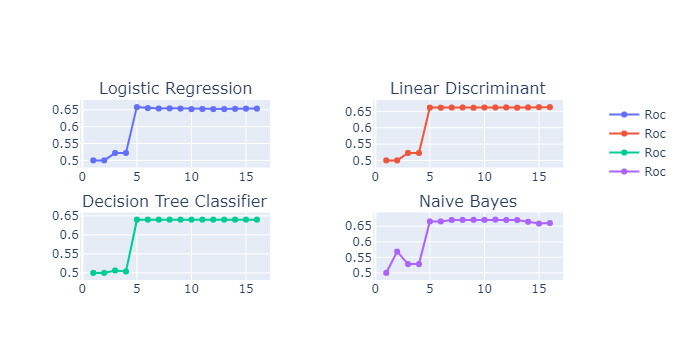

In [41]:
fig = make_subplots(rows=2, cols=2, 
                    specs = [[{"secondary_y": True}, {"secondary_y":True}],[{"secondary_y": True}, {"secondary_y":True}]],
                   subplot_titles=(best_models[0], 
                                   best_models[1], best_models[2], best_models[3]))
counter = 0
for row in range(1,3):
    for col in range(1,3):
    
        fig.add_trace(
            go.Scatter(x=perf[perf.model == best_models[counter]].index, 
                       y=perf[perf.model == best_models[counter]]["roc"],
                      name="Roc"),
            row=row, col=col
        )

        counter += 1
fig.show()


In [42]:
Feature_importances.index[:5]

Index(['feature_108', 'feature_297', 'feature_336', 'feature_223',
       'feature_307'],
      dtype='object')

In [43]:
for classifier in best_models:
    print(f"{classifier} : \n")
    score_classifier(dataset[Feature_importances.index[:5]],classifiers[classifier],labels, n_splits = 3)
    print("\n")

Logistic Regression : 

Confusion matrix : [[35130.  4184.]
 [ 9641.  7045.]]
recall in test is: 0.422201715560304 and recall in train is 0.4228851717420928
precision in test is: 0.6273418565361997 and precision in train is 0.6268409802012553
precision in test is: 0.6273418565361997 and precision in train is 0.6268409802012553
roc auc score in test is: 0.6578899615572299 and roc aus score in train is 0.6580260434565816


Linear Discriminant : 

Confusion matrix : [[34955.  4359.]
 [ 9442.  7244.]]
recall in test is: 0.4341094098303437 and recall in train is 0.43412848861935305
precision in test is: 0.6242381149980775 and precision in train is 0.6243789346593213
precision in test is: 0.6242381149980775 and precision in train is 0.6243789346593213
roc auc score in test is: 0.6616162500821475 and roc aus score in train is 0.6616449168902951


Decision Tree Classifier : 

Confusion matrix : [[35628.  3686.]
 [10446.  6240.]]
recall in test is: 0.37391345914334534 and recall in train is 0.3

## Grid search

In [48]:
classifiers_gridsearch = {"Logistic Regression":{"model":LogisticRegression(), "parameters":{'C':[1,10,20], 
              'solver':['lbfgs','liblinear'],
             'max_iter':[100,125,150]}},
                         "Linear Discriminant":{"model":LinearDiscriminantAnalysis(), "parameters":{
              'n_components':[0,1],
              'solver':['svd','lsqr','eigen']}}}
                          
gridsearch_models = {}                         
for classifier in classifiers_gridsearch.keys():
    print(f"{classifier} : \n")
    parameters = classifiers_gridsearch[classifier]["parameters"]
    gridsearch = GridSearchCV(classifiers_gridsearch[classifier]["model"],parameters, scoring = "f1", cv = 3) #The f1 score combines precision and recall
    score_classifier(dataset[Feature_importances.index[:5]],gridsearch,labels, n_splits = 3)
    gridsearch_models[classifier] = gridsearch
    print("\n")

Logistic Regression : 

Confusion matrix : [[35130.  4184.]
 [ 9641.  7045.]]
recall in test is: 0.422201715560304 and recall in train is 0.4228851717420928
precision in test is: 0.6273418565361997 and precision in train is 0.6268127456507837
precision in test is: 0.6273418565361997 and precision in train is 0.6268127456507837
roc auc score in test is: 0.6578899615572299 and roc aus score in train is 0.6580196952175831


Linear Discriminant : 

Confusion matrix : [[34955.  4359.]
 [ 9442.  7244.]]
recall in test is: 0.4341094098303437 and recall in train is 0.43412848861935305
precision in test is: 0.6242381149980775 and precision in train is 0.6243789346593213
precision in test is: 0.6242381149980775 and precision in train is 0.6243789346593213
roc auc score in test is: 0.6616162500821475 and roc aus score in train is 0.6616449168902951




In [46]:
classifier = "Linear Discriminant"
gridsearch_models[classifier]

GridSearchCV(cv=3, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'n_components': [0, 1],
                         'solver': ['svd', 'lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

,id,target,feature_0,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_55,feature_56,feature_57,feature_58,feature_59,feature_62,feature_63,feature_65,feature_66,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_80,feature_82,feature_87,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_111,feature_112,feature_114,feature_115,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_133,feature_134,feature_135,feature_136,feature_141,feature_142,feature_143,feature_147,feature_148,feature_149,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_199,feature_205,feature_209,feature_210,feature_211,feature_213,feature_215,feature_217,feature_218,feature_219,feature_221,feature_222,feature_223,feature_225,feature_227,feature_228,feature_229,feature_231,feature_232,feature_233,feature_235,feature_236,feature_237,feature_238,feature_240,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_251,feature_252,feature_261,feature_263,feature_265,feature_267,feature_269,feature_270,feature_271,feature_272,feature_273,feature_275,feature_276,feature_277,feature_279,feature_281,feature_283,feature_284,feature_285,feature_286,feature_287,feature_289,feature_290,feature_291,feature_292,feature_294,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_341,feature_343,feature_345,feature_347,feature_349,feature_351,feature_353,feature_355,feature_357,feature_358,feature_359,feature_361,feature_363,feature_365,feature_367,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_445,feature_446,feature_447,feature_448,feature_449,feature_450,feature_451,feature_452,feature_453,feature_454,feature_455,feature_456,feature_457,feature_458,feature_459,feature_460,feature_461,feature_462,feature_463,feature_464,feature_465,feature_466,feature_

validate our results on the validation set:

In [52]:
df_scaled

,id,target,feature_0,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_55,feature_56,feature_57,feature_58,feature_59,feature_62,feature_63,feature_65,feature_66,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_80,feature_82,feature_87,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_111,feature_112,feature_114,feature_115,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_133,feature_134,feature_135,feature_136,feature_141,feature_142,feature_143,feature_147,feature_148,feature_149,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_199,feature_205,feature_209,feature_210,feature_211,feature_213,feature_215,feature_217,feature_218,feature_219,feature_221,feature_222,feature_223,feature_225,feature_227,feature_228,feature_229,feature_231,feature_232,feature_233,feature_235,feature_236,feature_237,feature_238,feature_240,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_251,feature_252,feature_261,feature_263,feature_265,feature_267,feature_269,feature_270,feature_271,feature_272,feature_273,feature_275,feature_276,feature_277,feature_279,feature_281,feature_283,feature_284,feature_285,feature_286,feature_287,feature_289,feature_290,feature_291,feature_292,feature_294,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_341,feature_343,feature_345,feature_347,feature_349,feature_351,feature_353,feature_355,feature_357,feature_358,feature_359,feature_361,feature_363,feature_365,feature_367,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_445,feature_446,feature_447,feature_448,feature_449,feature_450,feature_451,feature_452,feature_453,feature_454,feature_455,feature_456,feature_457,feature_458,feature_459,feature_460,feature_461,feature_462,feature_463,feature_464,feature_465,feature_466,feature_

In [55]:
columns_to_keep = list(Feature_importances.index[:5])
columns_to_keep

['feature_108', 'feature_297', 'feature_336', 'feature_223', 'feature_307']

In [57]:
df_scaled

,id,target,feature_0,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_55,feature_56,feature_57,feature_58,feature_59,feature_62,feature_63,feature_65,feature_66,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_80,feature_82,feature_87,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_111,feature_112,feature_114,feature_115,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_133,feature_134,feature_135,feature_136,feature_141,feature_142,feature_143,feature_147,feature_148,feature_149,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_199,feature_205,feature_209,feature_210,feature_211,feature_213,feature_215,feature_217,feature_218,feature_219,feature_221,feature_222,feature_223,feature_225,feature_227,feature_228,feature_229,feature_231,feature_232,feature_233,feature_235,feature_236,feature_237,feature_238,feature_240,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_251,feature_252,feature_261,feature_263,feature_265,feature_267,feature_269,feature_270,feature_271,feature_272,feature_273,feature_275,feature_276,feature_277,feature_279,feature_281,feature_283,feature_284,feature_285,feature_286,feature_287,feature_289,feature_290,feature_291,feature_292,feature_294,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_341,feature_343,feature_345,feature_347,feature_349,feature_351,feature_353,feature_355,feature_357,feature_358,feature_359,feature_361,feature_363,feature_365,feature_367,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_445,feature_446,feature_447,feature_448,feature_449,feature_450,feature_451,feature_452,feature_453,feature_454,feature_455,feature_456,feature_457,feature_458,feature_459,feature_460,feature_461,feature_462,feature_463,feature_464,feature_465,feature_466,feature_

In [60]:
df_val_scaled = df_val.copy()
df_val_scaled.iloc[:,:-1] = scaler.transform(df_val_scaled.iloc[:,:-1])

dataset_val = df_val_scaled.loc[:,list(set(columns_to_keep))]
labels_val = df_val_scaled["target"]

for classifier in classifiers_gridsearch.keys():
    print(f"{classifier} : \n")
    model = gridsearch_models[classifier]
    y_pred = model.predict(dataset_val)
    confusion_mat = confusion_matrix(labels_val,y_pred)
    recall_val  = recall_score(labels_val,y_pred)
    precision_val = precision_score(labels_val,y_pred)
    roc_vol = roc_auc_score(labels_val, y_pred)
    print("Confusion matrix :",confusion_mat)
    print(f"recall is: {recall_val}")
    print(f"precision is: {precision_val} ")
    print(f"roc score is:{roc}")
    print("\n")
    

Logistic Regression : 

Confusion matrix : [[5174 4639]
 [2269 1918]]
recall is: 0.4580845474086458
precision is: 0.2925118194296172 
roc score is:0.6631373259141995


Linear Discriminant : 

Confusion matrix : [[4786 5027]
 [2156 2031]]
recall is: 0.4850728445187485
precision is: 0.28775857183338055 
roc score is:0.6631373259141995




As we can see our models are stable on the validation set

In [95]:
df_test_read = pd.read_csv("data/test.csv")
df_test_read

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,fe

In [82]:
df_test = df_test.loc[:,list(set(columns_to_keep))]
for key in mapping_dict.keys():
    if key in df_test.columns:
        df_test[key].replace(mapping_dict[key], inplace = True)

In [83]:
df_test

,feature_297,feature_307,feature_336,feature_223,feature_108
0,2,0,0,1146,0
1,0,0,0,0,2
2,0,0,0,0,0
3,0,0,0,1401,1
4,0,0,0,0,2
...,...,...,...,...,...
29995,2,1,0,1443,1
29996,2,0,0,12,1
29997,2,0,0,1086,2
29998,2,1,0,0,1


In [84]:
# We will predict the test for the Kaggle challenge
scaler = MinMaxScaler()

In [88]:
scaler.fit_transform(df_test)

array([[1.        , 0.        , 0.        , 0.00422574, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       ...,
       [1.        , 0.        , 0.        , 0.0040045 , 1.        ],
       [1.        , 1.        , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 0.12205977, 1.        ]])

In [91]:
df_test.iloc[:,:] = scaler.fit_transform(df_test)
dataset_test = df_test.loc[:,list(set(columns_to_keep))]
Predictions = {}
for classifier in classifiers_gridsearch.keys():
    print(f"{classifier} : \n")
    model = gridsearch_models[classifier]
    y_pred = model.predict(dataset_test)
    Predictions[classifier] = y_pred

Logistic Regression : 

Linear Discriminant : 



In [94]:
df_test

,feature_297,feature_307,feature_336,feature_223,feature_108
0,1.0,0.0,0.0,0.004226,0.0
1,0.0,0.0,0.0,0.000000,1.0
2,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.005166,0.5
4,0.0,0.0,0.0,0.000000,1.0
...,...,...,...,...,...
29995,1.0,1.0,0.0,0.005321,0.5
29996,1.0,0.0,0.0,0.000044,0.5
29997,1.0,0.0,0.0,0.004004,1.0
29998,1.0,1.0,0.0,0.000000,0.5


In [112]:
predictions = pd.DataFrame({"id":df_test_read.id.values, "target": Predictions["Linear Discriminant"]}).set_index("id")

In [113]:
predictions.to_csv("data/predictions_linear_discriminant.csv")

# Neural networks

In [349]:
# Import libraries and the data we want to use
import tensorflow as tf
from tensorflow import keras

df_nn = pd.read_csv("data/train.csv")

In [350]:
df_nn.head()

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature

In [351]:
# Create a list of numerical and categorical features
list_columns = list(df_nn.columns)
numerical_cols = []
categorical_cols = []
dates = []
for column in list_columns:
    if df_nn[column].dtype == 'int64' or df_nn[column].dtype == 'float64':
        df_nn[column].fillna(df_nn[column].mean())
        numerical_cols.append(column)
    elif '/' in df_nn[column][df_nn[column].first_valid_index()]:
        dates.append(column)
        df_nn[column] = pd.to_datetime(df_nn[column])
        #df_nn[column].fillna(df_nn[column].min())
        #df_nn[column] = (df_nn[column] - df_nn[column].min()).dt.total_seconds()
        
    else:
        categorical_cols.append(column)
        df_nn[column] = df_nn[column].map(lambda x: float(x[1:]))
        #df_nn[column] = df_nn[column].fillna(df_nn[column].mean())
print(f"number of numerical cols is : {len(numerical_cols)}")
print(f"number of categorical cols is : {len(categorical_cols)}")
print(f"number of date cols is : {len(dates)}")

number of numerical cols is : 417
number of categorical cols is : 82
number of date cols is : 10


In [352]:
# Create year month and day columns from date columns
for column in dates:
    df_nn[column +"_year"] = df_nn[column].map(lambda x: x.year)
    df_nn[column + "_month"] =  df_nn[column].map(lambda x: x.month)
    df_nn[column + "_day"] =  df_nn[column].map(lambda x: x.day)
    df_nn = df_nn.drop(column, axis = 1)

In [353]:
df_nn[numerical_cols]

,id,target,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_25,feature_26,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_56,feature_57,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_193,feature_196,feature_197,feature_198,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_245,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_43

In [354]:
df_nn_1 = df_nn[df_nn.target == 1]
df_nn_0 = df_nn[df_nn.target == 0].sample(int(len(df_nn_1)))


In [355]:
# Shuffle data
df_nn = pd.concat([df_nn_0, df_nn_1]).sample(frac = 1)

In [356]:
df_nn = df_nn.fillna(df_nn.mean())

In [357]:
df_nn = df_nn.dropna(axis = 1)

In [358]:
df_nn.isna().sum().max()

0

In [359]:
df_nn

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature

In [360]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.int64)

    return x, y

# Define a function that will one hot encode our classes 
def create_dataset(xs, ys, n_classes=2):
    ys = tf.one_hot(ys, depth=n_classes)
    return tf.data.Dataset.from_tensor_slices((xs, ys)) \
        .map(preprocess) \
        .shuffle(len(ys)) \
        .batch(128)

In [361]:
df_val = df_nn.sample(frac = 0.2, random_state = 96)
df_nn = df_nn[~df_nn.index.isin(df_val.index)]

In [362]:
x_train = df_nn.drop(["target", "id"], axis = 1)
y_train = df_nn["target"]

x_val = df_val.drop(["target", "id"], axis = 1)
y_val = df_val["target"]

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_train = tf.reshape(x_train, (len(x_train), x_train.shape[1],1))
x_val = scaler.transform(x_val)
x_val = tf.reshape(x_val, (len(x_val), x_val.shape[1],1))

In [363]:
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)

In [370]:
model = keras.Sequential([
    keras.layers.Conv1D(124, kernel_size=2, activation='relu', input_shape=(x_train.shape[1],1)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=2, activation='softmax')
])

In [371]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 522, 124)          372       
_________________________________________________________________
flatten_18 (Flatten)         (None, 64728)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 32)                2071328   
_________________________________________________________________
dense_52 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_53 (Dense)             (None, 2)                 34        
Total params: 2,072,262
Trainable params: 2,072,262
Non-trainable params: 0
_________________________________________________________________


In [374]:
# Train the model

model.compile(optimizer='adam', 
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_dataset.repeat(), 
    epochs=100, 
    steps_per_epoch=50,
    validation_data=val_dataset.repeat(), 
    validation_steps=2
)

Train for 50 steps, validate for 2 steps
Epoch 1/100
50/50 [==============================] - 9s 187ms/step - loss: 0.6603 - accuracy: 0.6005 - val_loss: 0.6513 - val_accuracy: 0.6055
Epoch 2/100
50/50 [==============================] - 5s 106ms/step - loss: 0.6086 - accuracy: 0.6855 - val_loss: 0.5789 - val_accuracy: 0.7266
Epoch 3/100
50/50 [==============================] - 5s 109ms/step - loss: 0.5957 - accuracy: 0.7003 - val_loss: 0.6190 - val_accuracy: 0.6719
Epoch 4/100
50/50 [==============================] - 5s 105ms/step - loss: 0.5981 - accuracy: 0.6952 - val_loss: 0.5661 - val_accuracy: 0.7383
Epoch 5/100
50/50 [==============================] - 5s 107ms/step - loss: 0.5875 - accuracy: 0.7089 - val_loss: 0.5777 - val_accuracy: 0.7109
Epoch 6/100
50/50 [==============================] - 9s 172ms/step - loss: 0.5959 - accuracy: 0.6989 - val_loss: 0.5770 - val_accuracy: 0.7227
Epoch 7/100
50/50 [==============================] - 5s 105ms/step - loss: 0.5946 - accuracy: 0.6998 

In [375]:
# AUC for training
y_pred = np.array([(lambda x: np.argmax(x))(x) for x in model.predict(x_train)])
roc_auc_score(y_train, y_pred)

0.7333578563696023

In [376]:
# AUC for validation
y_pred = np.array([(lambda x: np.argmax(x))(x) for x in model.predict(x_val)])
roc_auc_score(y_val, y_pred)

0.7083395786440903

In [388]:
df_test = pd.read_csv("data/test.csv")
df_nn_copy = df_nn.copy()

In [389]:
# Create a list of numerical and categorical features
df_nn = df_test
list_columns = list(df_nn.columns)
numerical_cols = []
categorical_cols = []
dates = []
for column in list_columns:
    if df_nn[column].dtype == 'int64' or df_nn[column].dtype == 'float64':
        df_nn[column].fillna(df_nn[column].mean())
        numerical_cols.append(column)
    elif '/' in df_nn[column][df_nn[column].first_valid_index()]:
        dates.append(column)
        df_nn[column] = pd.to_datetime(df_nn[column])
        #df_nn[column].fillna(df_nn[column].min())
        #df_nn[column] = (df_nn[column] - df_nn[column].min()).dt.total_seconds()
        
    else:
        categorical_cols.append(column)
        df_nn[column] = df_nn[column].map(lambda x: float(x[1:]))
        #df_nn[column] = df_nn[column].fillna(df_nn[column].mean())
print(f"number of numerical cols is : {len(numerical_cols)}")
print(f"number of categorical cols is : {len(categorical_cols)}")
print(f"number of date cols is : {len(dates)}")

number of numerical cols is : 416
number of categorical cols is : 82
number of date cols is : 10


In [390]:
for column in dates:
    df_nn[column +"_year"] = df_nn[column].map(lambda x: x.year)
    df_nn[column + "_month"] =  df_nn[column].map(lambda x: x.month)
    df_nn[column + "_day"] =  df_nn[column].map(lambda x: x.day)
    df_nn = df_nn.drop(column, axis = 1)

In [391]:
df_nn = df_nn[df_nn_copy.drop("target", axis = 1).columns]
df_nn = df_nn.fillna(df_nn.mean())
df_nn.isna().sum().max()

0

In [385]:
x_train.shape

TensorShape([33397, 523, 1])

In [392]:
df_nn.drop("id", axis = 1).values.shape

(30000, 523)

In [393]:
scaler.transform(df_nn.drop("id", axis = 1).values)

array([[0.        , 0.        , 0.        , ..., 0.89182243, 0.45351092,
        0.45977643],
       [0.        , 0.        , 0.6       , ..., 0.89182243, 0.45351092,
        0.45977643],
       [0.        , 0.        , 0.2       , ..., 0.89182243, 0.45351092,
        0.45977643],
       ...,
       [0.        , 0.        , 0.8       , ..., 0.91666667, 0.09090909,
        0.6       ],
       [0.        , 0.        , 0.        , ..., 0.91666667, 0.27272727,
        0.56666667],
       [0.        , 0.        , 0.8       , ..., 0.79166667, 0.63636364,
        0.36666667]])

In [394]:
# Scaling the test data and transforming to tensor
x_test = scaler.transform(df_nn.drop("id", axis = 1).values)
x_test = tf.cast(x_test, tf.float32)

In [395]:
x_train.shape

TensorShape([33397, 523, 1])

In [396]:
x_test.shape[1]

523

In [397]:
# Reshape the test data to use for predict
x_test = tf.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [398]:
# Predicting
predictions = model.predict(x_test)


In [399]:
# Use the argmax to get the class in our predicitions
predictions_map = np.array([(lambda x: np.argmax(x))(x) for x in predictions])

In [400]:
predictions_map.mean()

0.41996666666666665

In [401]:
pd.DataFrame({"id":df_test.id, "target":predictions_map}).set_index("id").to_csv("data/predcitions_nn_07_02_4.csv")